**Goal**: To finetune a model using GRPO(Group Relative Policy Optimization)
* Note: Every parameter used is tailored to complete the task on google colab free tier GPU.

**Install packages**

In [ ]:
!pip install -qqq datasets==3.2.0 transformers==4.47.1 trl==0.14.0 peft==0.14.0 accelerate==1.2.1 bitsandbytes==0.45.2 wandb==0.19.7 --progress-bar off
!pip install -qqq flash-attn --no-build-isolation --progress-bar off

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
  Preparing metadata (setup.py) ... done


**Import packages**

In [ ]:
import torch
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from transformers import AutoModelForCausalLM, AutoTokenizer
from trl import GRPOConfig, GRPOTrainer

**Load dataset**

In [ ]:
dataset = load_dataset("mlabonne/smoltldr")
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/981 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.44M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/151k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/151k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/200 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 200
    })
    test: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 200
    })
})


**Taking only 500 samples to reduce training time**

In [ ]:
from datasets import DatasetDict  # ✅ Import DatasetDict

# Reduce dataset size to speed up training
train_size = 500  # Reduce train set to 500 samples
val_size = 200    # Keep validation set as is
test_size = 200   # Keep test set as is

# Assuming `dataset` is already loaded
dataset = DatasetDict({
    "train": dataset["train"].shuffle(seed=42).select(range(train_size)),
    "validation": dataset["validation"].shuffle(seed=42).select(range(val_size)),
    "test": dataset["test"].shuffle(seed=42).select(range(test_size)),
})

# Print new dataset sizes
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 200
    })
    test: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 200
    })
})


**Checking the dataset sample**

In [ ]:
dataset['test'][0]

{'prompt': "SUBREDDIT: r/personalfinance\n\nTITLE: I can't get approved for a credit card. How do I build credit?\n\nPOST: A little backstory: I'm 27. When I was in my early twenties, I opened a card with a $1,000 limit. Maxed it out and didn't pay it for a few years. I also had a checking account go to collections for being negative too long. Also, stopped attending school and didn't pay my loans for a few years. \n\nWithin the last two years, I've paid off everything on my credit report in full, with the exception of my student loans. I've made every loan payment on time for the last two years, (automatic payments) and have about $7,000 left. I bought a car and have made more than the minimum payment and have never been late. \n\nBut I still have a low credit score and am wondering how to fix it. I applied for a credit card with Discover and got denied. It says due to outstanding non-payment. I'm worried that there's something on my credit report that I missed, but I don't want to pa

**Defining the model and tokenizer**

In [ ]:
model_id = "HuggingFaceTB/SmolLM-135M-Instruct"
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype="auto",
    device_map="auto",
    # attn_implementation="flash_attention_2",
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

**Defining the LoRA and parameters and applying it to model**

In [ ]:
# Load LoRA
lora_config = LoraConfig(
    task_type="CAUSAL_LM",
    r=16,
    lora_alpha=32,
    target_modules="all-linear",
)
model = get_peft_model(model, lora_config)
print(model.print_trainable_parameters())

trainable params: 4,884,480 || all params: 139,399,488 || trainable%: 3.5039
None


**In this use case, I will be using completion length as reward**

In [ ]:
# Reward function
ideal_length = 50


def reward_len(completions, **kwargs):
    return [-abs(ideal_length - len(completion)) for completion in completions]

**Defining the training parameters**

In [ ]:
# Modified Training Arguments for Google Colab Free Tier
training_args = GRPOConfig(
    output_dir="GRPO",
    learning_rate=2e-5,
    per_device_train_batch_size=2,  # Reduced batch size to fit in memory
    gradient_accumulation_steps=4,  # Increased for better memory efficiency
    max_prompt_length=256,  # Reduced to save memory
    max_completion_length=96,
    num_generations=8,
    optim="adamw_8bit",  # 8-bit optimizer to save VRAM
    num_train_epochs=1,
    fp16=True,  # Changed from bf16 → fp16 (Colab Free doesn't support bf16)
    report_to=["wandb"],
    remove_unused_columns=False,
    logging_steps=10,  # Adjusted for better logging frequency
)


**Fine-tuning the model**

In [ ]:
# Trainer
trainer = GRPOTrainer(
    model=model,
    reward_funcs=[reward_len],
    args=training_args,
    train_dataset=dataset["train"],
)

# Train model
wandb.init(project="GRPO")
trainer.train()

Step,Training Loss
10,0.000000
20,0.000000
30,0.000100
40,0.000100
50,0.000200
60,0.000200


TrainOutput(global_step=62, training_loss=0.00012314702654557844, metrics={'train_runtime': 2350.8181, 'train_samples_per_second': 0.213, 'train_steps_per_second': 0.026, 'total_flos': 0.0, 'train_loss': 0.00012314702654557844})

**Note**: You might notice that the loss starts at zero and then increases during training, which may seem counterintuitive. This behavior is expected in GRPO and is directly related to the mathematical formulation of the algorithm. The loss in GRPO is proportional to the KL divergence (the cap relative to original policy) . As training progresses, the model learns to generate text that better matches the reward function, causing it to diverge more from its initial policy. This increasing divergence is reflected in the rising loss value, which actually indicates that the model is successfully adapting to optimize for the reward function.

**Push the finetuned model to hugging face**

In [ ]:
merged_model = trainer.model.merge_and_unload()
merged_model.push_to_hub(
    "SmolGRPO-135M", private=False, tags=["GRPO", "Reasoning-Course"]
)

**Input prompt to test**

In [ ]:
prompt = """
# A long document about the Cat

The cat (Felis catus), also referred to as the domestic cat or house cat, is a small
domesticated carnivorous mammal. It is the only domesticated species of the family Felidae.
Advances in archaeology and genetics have shown that the domestication of the cat occurred
in the Near East around 7500 BC. It is commonly kept as a pet and farm cat, but also ranges
freely as a feral cat avoiding human contact. It is valued by humans for companionship and
its ability to kill vermin. Its retractable claws are adapted to killing small prey species
such as mice and rats. It has a strong, flexible body, quick reflexes, and sharp teeth,
and its night vision and sense of smell are well developed. It is a social species,
but a solitary hunter and a crepuscular predator. Cat communication includes
vocalizations—including meowing, purring, trilling, hissing, growling, and grunting—as
well as body language. It can hear sounds too faint or too high in frequency for human ears,
such as those made by small mammals. It secretes and perceives pheromones.
"""

messages = [
    {"role": "user", "content": prompt},
]

**Loading and testing the model**

In [ ]:
# Generate text
from transformers import pipeline

generator = pipeline("text-generation", model="nharshavardhana/SmolGRPO-135M",tokenizer=tokenizer)

## Or use the model and tokenizer we defined earlier
# generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

generate_kwargs = {
    "max_new_tokens": 256,
    "do_sample": True,
    "temperature": 0.5,
    "min_p": 0.1,
}

generated_text = generator(messages, **generate_kwargs)

print(generated_text)

Device set to use cuda:0


[{'generated_text': [{'role': 'user', 'content': '\n# A long document about the Cat\n\nThe cat (Felis catus), also referred to as the domestic cat or house cat, is a small \ndomesticated carnivorous mammal. It is the only domesticated species of the family Felidae.\nAdvances in archaeology and genetics have shown that the domestication of the cat occurred\nin the Near East around 7500 BC. It is commonly kept as a pet and farm cat, but also ranges\nfreely as a feral cat avoiding human contact. It is valued by humans for companionship and\nits ability to kill vermin. Its retractable claws are adapted to killing small prey species\nsuch as mice and rats. It has a strong, flexible body, quick reflexes, and sharp teeth,\nand its night vision and sense of smell are well developed. It is a social species,\nbut a solitary hunter and a crepuscular predator. Cat communication includes\nvocalizations—including meowing, purring, trilling, hissing, growling, and grunting—as\nwell as body language. 

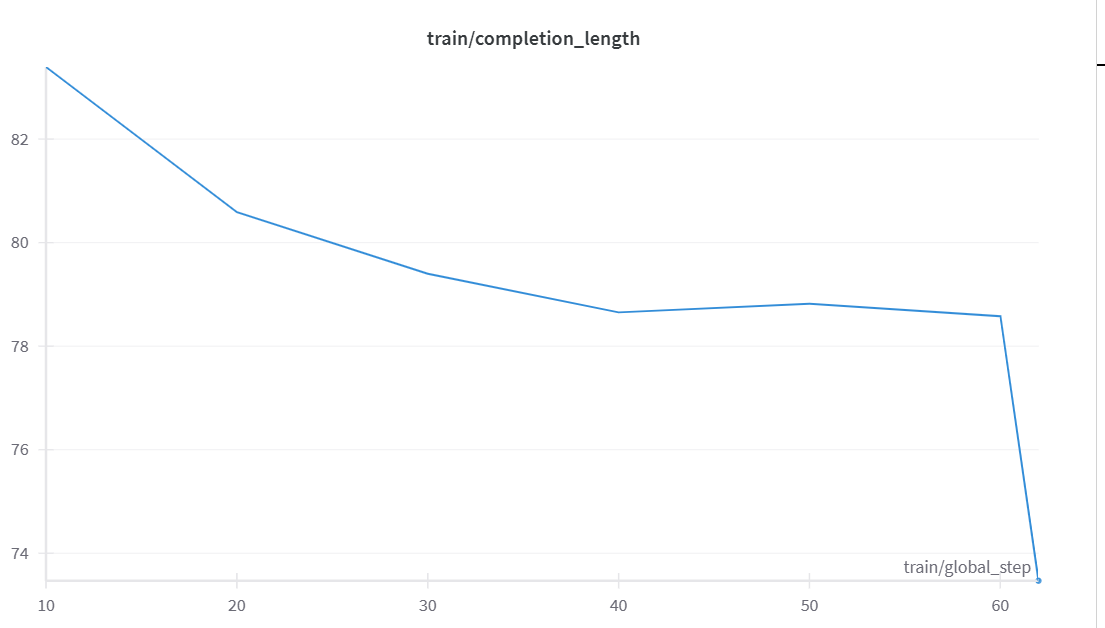

In [1]:
from IPython.display import display
from PIL import Image

image_path = "completion_length.png"  # Replace with your actual image path
img = Image.open(image_path)
display(img)


From the image it can be seen that the reward from the reward function (completion length) is decreasing and moves closer to 0 as the model learns. This is a good sign that the model is learning to generate text of the correct length.